# <center><div style="color:red">IMAGE SEGMENTATION WITH U-NET</div></center>

### <font color='blue'> Table of Contents </font>
- [1 - Objectives](#1)
- [2 - Setup](#2)
- [3 - Helper Functions](#3)
- [4 - Data](#4) <br>
    - [4.1. - Generating Synthetic Data](#4.1)
    - [4.2. - Pre-procesing](#4.2)
- [5 - Build, compile and train the model](#5)
- [6 - Predictions](#6)
- [7 - Evaluation](#7)
- [8 - Training with Dice Loss](#8)
- [9 - References](#references)

<a name="1"></a> 
## <font color="orange"> <b> 1. Introduction </b> </font>
In this notebook, we explore image segmentation using the U-Net architecture, a powerful convolutional neural network originally designed for biomedical image segmentation. To simplify the pipeline and focus on the core concepts, we generate synthetic data — artificial images and masks — allowing us to quickly prototype and evaluate the model.

**Goals:**

- Understand the principles of semantic segmentation.

- Generate synthetic image-mask pairs for training.

- Implement and train a U-Net model from scratch (or using PyTorch/Keras).

- Evaluate segmentation performance visually and quantitatively.

This hands-on approach provides a clear, minimal setup to grasp the fundamentals of U-Net and segmentation workflows before applying them to real-world datasets.

<a name="2"></a> 
## <font color="orange"> <b> 2. Setup </b> </font>

In [26]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import seaborn as sns

from dataclasses import dataclass

In [27]:
tf.random.set_seed(5)

In [28]:
# for default values
@dataclass
class DataConfig:
    batch_size: int = 32
    width: int = 224
    height: int = 224

G = DataConfig()

<a name="3"></a> 
## <font color="orange"> <b> 3. Helper Functions </b> </font>

In [54]:
def plot_image_mask_prediction(image, true_mask, pred_mask, title_prefix=''):
    """
    Plots the input image, ground truth mask, and predicted mask side by side.

    Args:
        image (np.array or tf.Tensor): Original image (H, W, 3)
        true_mask (np.array or tf.Tensor): Ground truth mask (H, W)
        pred_mask (np.array or tf.Tensor): Predicted mask (H, W)
        title_prefix (str): Optional prefix for plot titles
    """
    # Convert to numpy if needed
    if hasattr(image, 'numpy'): image = image.numpy()
    if hasattr(true_mask, 'numpy'): true_mask = true_mask.numpy()
    if hasattr(pred_mask, 'numpy'): pred_mask = pred_mask.numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.astype("uint8"))
    plt.title(f"{title_prefix}Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='jet', interpolation='none')
    plt.title(f"{title_prefix}Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='jet', interpolation='none')
    plt.title(f"{title_prefix}Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

<a name="4"></a> 
## <font color="orange"> <b> 4. Data </b> </font>

<a name="4.1"></a> 
### <font color="#ca6f1e"> <b> 4.1. Generating Synthetic Data </b> </font>

We will generate:

Input image: RGB image with shapes (square, circle, or both)

Segmentation mask: grayscale image where:

0 = background

1 = square

2 = circle


In [83]:
# pixel labels in the video frames
class_names = ['background','square','circle']

# number of different classes
num_classes = 3

In [84]:
import cv2
import random

# Output folders
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"
os.makedirs(image_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

# Parameters
num_samples = 200
img_size = 128
shape_colors = {
    "square": (255, 0, 0),  # Red
    "circle": (0, 255, 0),  # Green
}

for i in range(num_samples):
    img = np.ones((img_size, img_size, 3), dtype=np.uint8) * 255  # white background
    mask = np.zeros((img_size, img_size), dtype=np.uint8)         # 0=background

    shapes = random.choices(["square", "circle"], k=random.randint(1, 2))  # at least 1 shape

    for shape in shapes:
        x, y = random.randint(10, 90), random.randint(10, 90)
        size = random.randint(15, 30)

        if shape == "square":
            cv2.rectangle(img, (x, y), (x+size, y+size), shape_colors["square"], -1)
            cv2.rectangle(mask, (x, y), (x+size, y+size), 1, -1)
        elif shape == "circle":
            cv2.circle(img, (x, y), size//2, shape_colors["circle"], -1)
            cv2.circle(mask, (x, y), size//2, 2, -1)

    cv2.imwrite(f"{image_dir}/img_{i:03d}.png", img)
    cv2.imwrite(f"{mask_dir}/mask_{i:03d}.png", mask)


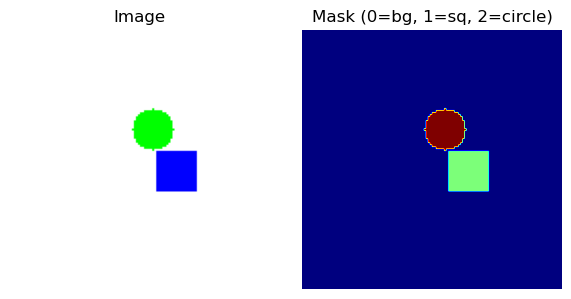

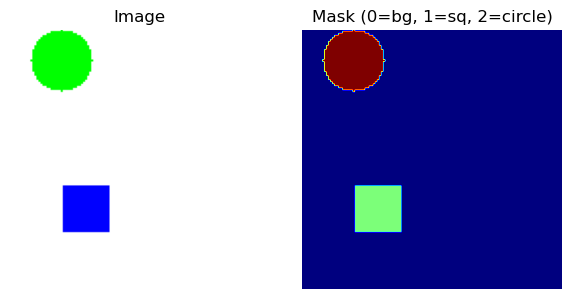

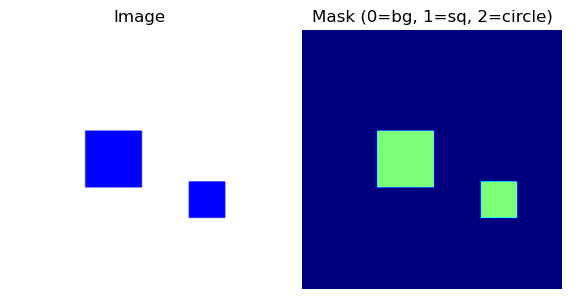

In [85]:
# Directories
image_dir = "synthetic_dataset/images"
mask_dir = "synthetic_dataset/masks"

# Number of samples to plot
num_samples_to_show = 3

# Get sample filenames
image_filenames = sorted(os.listdir(image_dir))[:num_samples_to_show]
mask_filenames = sorted(os.listdir(mask_dir))[:num_samples_to_show]

for img_file, mask_file in zip(image_filenames, mask_filenames):
    # Load image and mask
    img = cv2.imread(os.path.join(image_dir, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap='jet', vmin=0, vmax=2)
    axs[1].set_title("Mask (0=bg, 1=sq, 2=circle)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

<a name="4.2"></a> 
### <font color="#ca6f1e"> <b> 4.2. Pre-processing </b> </font>

**Train/Test Split**

In [86]:
from sklearn.model_selection import train_test_split
import shutil

# Set split ratio
train_ratio = 0.8

# Get all image/mask filenames
all_filenames = [f"img_{i:03d}.png" for i in range(num_samples)]
train_files, test_files = train_test_split(all_filenames, train_size=train_ratio, random_state=42)

# Create train/test folders
for split in ["train", "test"]:
    os.makedirs(f"synthetic_dataset/{split}/images", exist_ok=True)
    os.makedirs(f"synthetic_dataset/{split}/masks", exist_ok=True)

# Move files to appropriate folders
for split_files, split in [(train_files, "train"), (test_files, "test")]:
    for filename in split_files:
        shutil.move(f"{image_dir}/{filename}", f"synthetic_dataset/{split}/images/{filename}")
        shutil.move(f"{mask_dir}/mask_{filename[4:]}", f"synthetic_dataset/{split}/masks/mask_{filename[4:]}")


**Directories**

In [87]:
train_img_dir = "synthetic_dataset/train/images"
test_img_dir = "synthetic_dataset/test/images"
train_annotation_dir = "synthetic_dataset/train/masks"
test_annotation_dir = "synthetic_dataset/test/masks"

**Image & Mask Preprocessing Function**

In [88]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=G.height, width=G.width, num_classes=num_classes):
    """
    Reads and preprocesses an image and its corresponding segmentation mask from given file paths.

    Args:
        t_filename (tf.Tensor or str): Path to the input image file.
        a_filename (tf.Tensor or str): Path to the corresponding annotation (mask) file.
        height (int): Target height to resize the image and mask. Defaults to G.height.
        width (int): Target width to resize the image and mask. Defaults to G.width.
        num_classes (int): Number of segmentation classes for one-hot encoding. Defaults to num_classes.

    Returns:
        image (tf.Tensor): Preprocessed image tensor of shape (height, width, 3), normalized to [-1, 1].
        annotation (tf.Tensor): One-hot encoded mask tensor of shape (height, width, num_classes).
    """

    # Read and decode the image (3 channels)
    img_raw = tf.io.read_file(t_filename)
    image = tf.image.decode_png(img_raw, channels=3)
    image = tf.image.resize(image, (height, width))  # Resize image to desired size
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize pixel values to [-1, 1]

    # Read and decode the annotation mask (1 channel)
    anno_raw = tf.io.read_file(a_filename)
    annotation = tf.image.decode_png(anno_raw, channels=1)
    annotation = tf.image.resize(annotation, (height, width), method='nearest')  # Keep class labels intact
    annotation = tf.cast(annotation, tf.int32)
    annotation = tf.squeeze(annotation, axis=-1)  # Remove channel dimension (H, W, 1) -> (H, W)

    # Convert annotation to one-hot format: shape becomes (H, W, num_classes)
    annotation = tf.one_hot(annotation, depth=num_classes)

    return image, annotation


**Get image/mask paths**

In [89]:
def get_dataset_slice_paths(image_dir, label_map_dir):
    '''
    Returns sorted paths to image and mask files.
    '''
    image_file_list = sorted(os.listdir(image_dir))
    label_map_file_list = sorted(os.listdir(label_map_dir))

    image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
    label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

    return image_paths, label_map_paths


**TF Datasets**

In [96]:
# --------------------------
# 1. Create training dataset
# --------------------------

def get_training_dataset(image_paths, label_map_paths, batch_size = G.batch_size):
  '''
  Prepares shuffled batches of the training set.

  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set
    batch_size

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(batch_size)
  #training_dataset = training_dataset.repeat()
  #training_dataset = training_dataset.prefetch(1)

  return training_dataset


# --------------------------
# 2. Create validation dataset
# -------------------------

def get_validation_dataset(image_paths, label_map_paths, batch_size = G.batch_size):
  '''
  Prepares batches of the validation set.

  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(batch_size)
  #validation_dataset = validation_dataset.repeat()

  return validation_dataset

In [97]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths(train_img_dir, train_annotation_dir)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(test_img_dir, test_annotation_dir)

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

<a name="5"></a> 
## <font color="orange"> <b> 5. Build, compile and train the model </b> </font>

In [98]:
# U-NET
def unet_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)

    return models.Model(inputs, outputs)


In [99]:
model = unet_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [100]:
model.fit(training_dataset,
          validation_data=validation_dataset,
          epochs=2)


Epoch 1/2
5/5 [==============================] - 144s 28s/step - loss: 0.4817 - accuracy: 0.9572 - val_loss: 0.0717 - val_accuracy: 0.9752
Epoch 2/2
5/5 [==============================] - 138s 28s/step - loss: 0.0437 - accuracy: 0.9906 - val_loss: 0.0155 - val_accuracy: 0.9984


<a name="6"></a> 
## <font color="orange"> <b> 6. Predictions </b> </font>

Let's make a prediction.

In [126]:
# Unbatch to get individual (image, mask) pairs
unbatched_val_dataset = validation_dataset.unbatch()

# Get the 27th sample (0-based index)
for i, (image, mask) in enumerate(unbatched_val_dataset):
    if i == 27:
        image = image.numpy()
        mask = mask.numpy()
        break

# Convert mask from one-hot to class labels if needed
if mask.shape[-1] == 3:
    mask = np.argmax(mask, axis=-1)


In [127]:
image.shape

(224, 224, 3)

In [128]:
data = image

data = image[np.newaxis, ...] # add batch dimension
pred_mask = model.predict(data)

1/1 [==============================] - 0s 182ms/step


In [129]:
pred_mask.shape

(1, 224, 224, 3)

In [130]:
pred_mask = tf.argmax(pred_mask[0], axis=-1) # convert predictions to class indices
pred_mask = pred_mask[..., tf.newaxis]

In [131]:
pred_mask.shape

TensorShape([224, 224, 1])

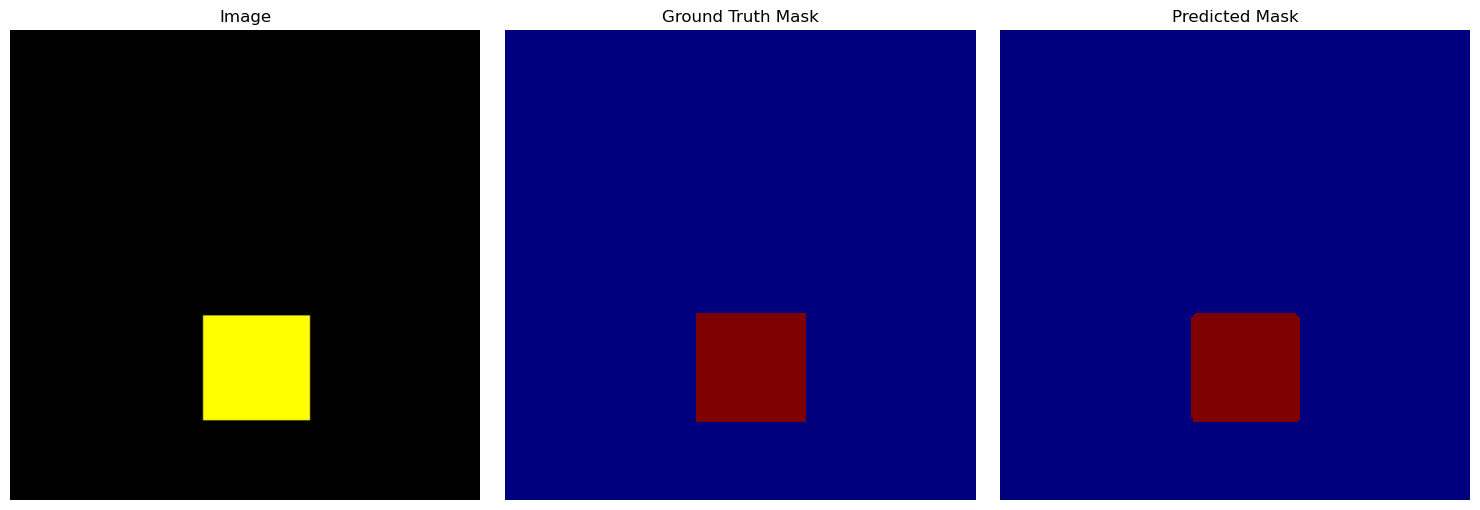

In [132]:
plot_image_mask_prediction(image, mask, pred_mask)

In [133]:
unique, counts = np.unique(mask_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 49108, 1: 1068}


<a name="7"></a> 
## <font color="orange"> <b> 7. Evaluation </b> </font>

We will calcuate the IoU.

In [109]:
def compute_iou(y_true, y_pred, num_classes=3):
    """
    Compute per-class IoU from one-hot encoded predictions and labels.

    Args:
        y_true: np.array, shape (H, W, num_classes) or (N, H, W, num_classes)
        y_pred: np.array, same shape as y_true (typically after softmax)
        num_classes: int, number of classes

    Returns:
        list of IoU per class
    """
    # Convert from one-hot to class indices
    y_true_argmax = np.argmax(y_true, axis=-1).flatten()
    y_pred_argmax = np.argmax(y_pred, axis=-1).flatten()

    ious = []
    for cls in range(num_classes):
        intersection = np.sum((y_true_argmax == cls) & (y_pred_argmax == cls))
        union = np.sum((y_true_argmax == cls) | (y_pred_argmax == cls))
        iou = intersection / (union + 1e-7)
        ious.append(iou)
    return ious


In [110]:
def compute_iou_dataset(model, dataset, num_classes=num_classes):
    total_intersection = np.zeros(num_classes)
    total_union = np.zeros(num_classes)

    for images, labels in dataset:
        preds = model.predict(images)

        # Convert to class indices
        y_true = tf.argmax(labels, axis=-1).numpy().flatten()
        y_pred = tf.argmax(preds, axis=-1).numpy().flatten()

        for cls in range(num_classes):
            intersection = np.sum((y_true == cls) & (y_pred == cls))
            union = np.sum((y_true == cls) | (y_pred == cls))
            total_intersection[cls] += intersection
            total_union[cls] += union

    iou_per_class = total_intersection / (total_union + 1e-7)
    mean_iou = np.mean(iou_per_class)

    return iou_per_class, mean_iou


In [111]:
iou_scores, mean_iou = compute_iou_dataset(model, validation_dataset)

print("Per-class IoU:", iou_scores)
print("Mean IoU:", mean_iou)

1/1 [==============================] - 1s 1s/step
Per-class IoU: [0.99841538 0.96492384 0.95339466]
Mean IoU: 0.9722446273854323


Per-class IoU:
[0.99, 0.96, 0.95]

- Class 0: Excellent (almost perfect) segmentation.

- Class 1: Very good.

- Class 2: Also very good.

Mean IoU:
0.97 → This is the average of all per-class IoUs and indicates excellent segmentation performance overall.

Our model is performing well with high Intersection over Union (IoU) for all classes.

<a name="8"></a> 
## <font color="orange"> <b> 8. Training with Dice Score </b> </font>

Previously, we trained the model using categorical_crossentropy as the loss function and monitored accuracy as the main metric. However, since this is an image segmentation problem, especially with class imbalance, these choices may not be ideal. In segmentation tasks, pixel-wise accuracy can be misleading—predicting the dominant class everywhere may yield high accuracy while completely missing smaller structures.

To address this, it's more appropriate to use a loss function tailored for segmentation and imbalance, such as:
- Dice Loss or 
- Jaccard Loss. 

These better capture the overlap between predicted and ground truth masks, focusing on the correct segmentation of all classes, including minority ones.

Additionally, we should monitor the Intersection over Union (IoU), which is a more meaningful metric for segmentation tasks. IoU provides a class-wise evaluation of segmentation quality and is particularly useful when evaluating models on unbalanced datasets.

In [76]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - tf.reduce_mean(dice)


In [79]:
# instanciate the model
model = unet_model()

# Compile
model.compile(
    optimizer="adam",
    loss=dice_loss,
    metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)]
)

In [80]:
# Train
model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=2,
)

Epoch 1/2
5/5 [==============================] - 139s 28s/step - loss: 0.3347 - mean_io_u_3: 0.3333 - val_loss: 0.0408 - val_mean_io_u_3: 0.3333
Epoch 2/2
5/5 [==============================] - 136s 27s/step - loss: 0.0427 - mean_io_u_3: 0.3333 - val_loss: 0.0408 - val_mean_io_u_3: 0.3333


In [81]:
iou_scores, mean_iou = compute_iou_dataset(model, validation_dataset)

print("Per-class IoU:", iou_scores)
print("Mean IoU:", mean_iou)

1/1 [==============================] - 1s 1s/step
Per-class IoU: [0.95922303 0.         0.        ]
Mean IoU: 0.3197410116390147


<a name="references"></a> 
## <font color="orange"> <b> References </b> </font>

[TF Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)